<a href="https://colab.research.google.com/github/andreacangiani/NSPDE-ANA2024/blob/main/Python/CP2_worked.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
import time

## Exercise 1

Find a way to evaluate execution time and compare full vs sparse execution time in function of the grid size N

In [5]:
# Define sparse and delse formulas:

def forw_diff(N):
    data=[-np.ones(N+1), np.ones(N)]
    return sp.diags(data,[0,1], format="csr")

def forw_diff_dense(N):
    return np.diag(-np.ones(N+1),0) + np.diag(np.ones(N),1)

In [6]:
# Define symbolic variables and functions and problem data

t = sym.var('t')
fsym = 0.5 * t**2
f = sym.lambdify(t, fsym)
fdsym = fsym.diff(t,1)
fd = sym.lambdify(t,fdsym)

a = 0
b = 1

In [7]:
# Compare execution time in the two cases varying the number of points

for N in [10**i for i in range(1,5)]:
    h = (b - a) / N
    x = np.linspace(a, b, N + 1)

    start_time_sparse = time.time()
    D_sparse = forw_diff(N) / h
    uh_sparse = D_sparse.dot(f(x))[1:N]
    end_time_sparse = time.time()

    start_time_dense = time.time()
    D_dense = forw_diff_dense(N) / h
    uh_dense = D_dense.dot(f(x))[1:N]
    end_time_dense = time.time()

    print(f"Grid size: {N}, Max error (sparse): {max(abs(uh_sparse-fd(x[1:N])))}, Execution time (sparse): {end_time_sparse - start_time_sparse} seconds")
    print(f"Grid size: {N}, Max error (dense): {max(abs(uh_dense-fd(x[1:N])))}, Execution time (dense): {end_time_dense - start_time_dense} seconds")

Grid size: 10, Max error (sparse): 0.05000000000000049, Execution time (sparse): 0.012351512908935547 seconds
Grid size: 10, Max error (dense): 0.05000000000000049, Execution time (dense): 0.0001609325408935547 seconds
Grid size: 100, Max error (sparse): 0.0050000000000051115, Execution time (sparse): 0.0011026859283447266 seconds
Grid size: 100, Max error (dense): 0.0050000000000051115, Execution time (dense): 0.01060342788696289 seconds
Grid size: 1000, Max error (sparse): 0.0005000000000854321, Execution time (sparse): 0.0027093887329101562 seconds
Grid size: 1000, Max error (dense): 0.0005000000000854321, Execution time (dense): 0.04040050506591797 seconds
Grid size: 10000, Max error (sparse): 5.00000021027569e-05, Execution time (sparse): 0.0026607513427734375 seconds
Grid size: 10000, Max error (dense): 5.00000021027569e-05, Execution time (dense): 1.2166872024536133 seconds


## Exercise 2

### Finite Differences for two-points boundary value problems with constant coefficients

Poisson problem in 1D:

$-u''(x)=f(x) \quad \in (a,b)$

$u(a)=0, \quad u(b)=0$

We use the second central divided difference to approxima the second derivative.

Given $h>0$,

$u''(x)≈\frac{u(x+h)-2u(x)+u(x-h)}{h^2}$

Define FD problem:

for $h=(b-a)/N$

$ A U = - h^2 F $

with $A$ the nominator of CD formula.

**Test for convergence and plot convergence plot.**

In [11]:
# Define formula, symbolic variables and data for the problem and the plot

def CD2(N):
    data = [np.ones(N), -2 * np.ones(N + 1), np.ones(N)]
    return sp.diags(data,[-1,0,1], format="csr")

t = sym.var('t')
fsym = sym.sin(t)
f = sym.lambdify(t, fsym )

usym = sym.sin(t)
u = sym.lambdify(t, usym )

a = 0
b = np.pi
Ns = [10, 20, 40, 80, 160, 320, 640, 1280]

In [9]:
errors = []

for N in Ns:
    h = (b - a) / N
    x = np.linspace(a, b, N + 1)
    A = CD2(N)
    F = -h**2 * f(x[1:-1])
    A = A[1:-1,1:-1]
    uh = spsolve(A, F)
    error = np.max(np.abs(uh-u(x[1:-1])))
    errors.append(error)

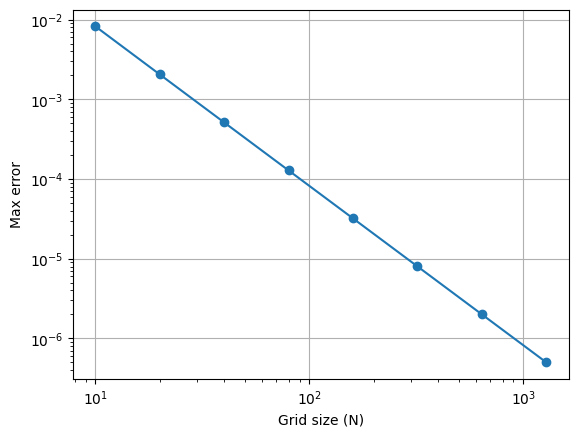

In [10]:
plt.loglog(Ns, errors, 'o-')
plt.xlabel('Grid size (N)')
plt.ylabel('Max error')
plt.grid(True)
plt.show()

## Exercise 3

Solve the problem with nonhomogeneous Dirichlet conditions:

$-\alpha u''(x)=f(x) \quad \in (a,b)$

$u(a)=u_a, \quad u(b)=u_b$

For example, you could fix: $(a,b)=(0,\pi/2)$, solution $u$ as before, $\alpha=\frac{1}{2}$

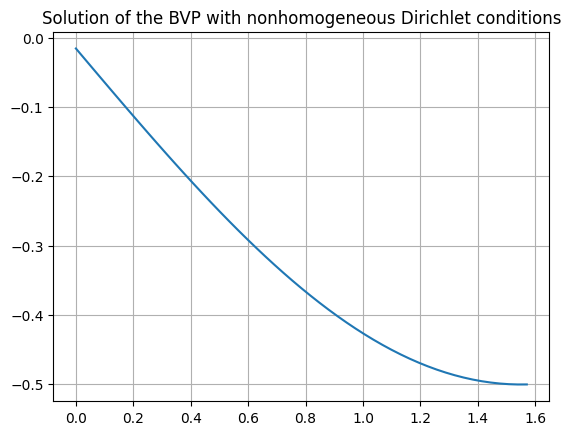

In [13]:
alpha = 0.5
fsym = -alpha * sym.sin(t)
f = sym.lambdify(t, fsym )
usym = -alpha * sym.sin(t)
u = sym.lambdify(t, usym )

a, b = 0, np.pi / 2
N = 50
u_a = 0
u_b = -alpha

h = (b - a) / N
x = np.linspace(a, b, N + 1)
A = CD2(N)
F = -h**2 * f(x)
F[0] -= u_a
F[-1] -= u_b
uh = sp.linalg.spsolve(A, F)

plt.plot(x,uh)
plt.title('Solution of the BVP with nonhomogeneous Dirichlet conditions')
plt.grid(True)
plt.show()

**Exercise 4.** Solve the problem with (homogeneous) Neumann conditions:

$-\alpha u''(x)=f(x) \quad \in (a,b)$

$u(a)=u_a, \quad u'(b)=0$

For example, you could fix: $(a,b)=(0,\pi/2)$, solution $u$ as before, $\alpha=1$.

In [15]:
def solve_bvp_neumann(a, b, N, alpha, rhs):
    h = (b - a) / N
    x = np.linspace(a, b, N + 1)

    diff = alpha(x)
    F = rhs(x)

    diff_term = [-diff[1:N + 1], 2*diff, -diff[:-1]]

    A = (1./h**2) * sp.diags(diff_term, [-1, 0, 1], format="csr")

    A[0, 0] = 1; A[0,1] = 0; F[0] = 0
    A[N, N] = 1; A[N, N-1] = 0; F[N] = 1

    return x, A, F

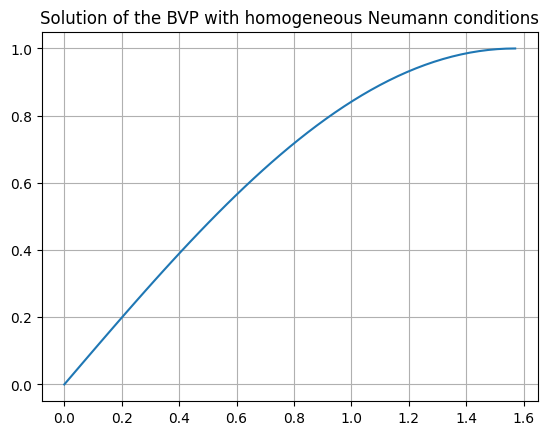

In [16]:
a, b = 0, np.pi/2

alpha = lambda x : np.ones(len(x))
rhs = lambda x : np.sin(x)

N = 50
x, A, F = solve_bvp_neumann(a, b, N, alpha, rhs)
uh = sp.linalg.spsolve(A, F)

plt.plot(x,uh)
plt.title('Solution of the BVP with homogeneous Neumann conditions')
plt.grid(True)
plt.show()

**Exercise 5.** Solve the reaction-advection-diffusion problem (still with central differences):

$-\alpha u''(x)+\beta u'(x)+\gamma u(x)=f(x) \quad \in (a,b)$

$u(a)=u_a, \quad u(b)=u_b$


In [17]:
def solve_reaction_advection_diffusion(omega, N, alpha, beta, gamma, rhs):

    h = (omega[1] - omega[0]) / N
    x = np.linspace(omega[0], omega[1], N + 1)

    diff = alpha(x)
    conv = beta(x)
    reac = gamma(x)
    F = rhs(x)

    diff_term = [-diff[1 : N + 1], 2 * diff, -diff[:-1]]
    conv_term = [-conv[1 : N + 1], conv[:-1]]

    A = (1./h**2) * sp.diags(diff_term, [-1,0,1], format="csr") + (1./(2 * h)) * sp.diags(conv_term,[-1,1],format="csr") + sp.diags(reac,0,format="csr")

    A[0,0] = 1; A[0,1] = 0; F[0] = 0
    A[N,N] = 1; A[N,N-1] = 0; F[N] = 0

    return A, F

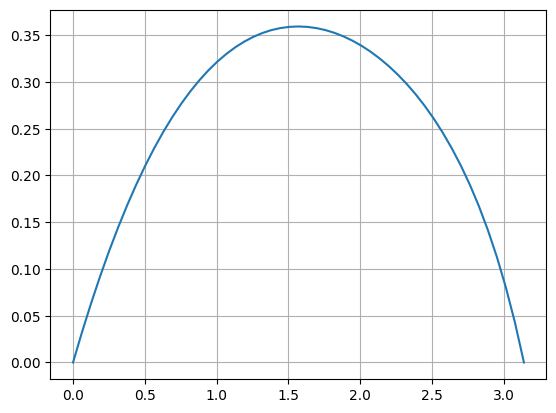

In [18]:
omega = [0, np.pi]
alpha = lambda x : 1 + np.sin(x)
beta = lambda x : np.ones(len(x))
gamma = lambda x : x
rhs = lambda x : np.ones(len(x))

N = 50
x = np.linspace(omega[0], omega[1], N + 1)

A, F = solve_reaction_advection_diffusion(omega, N, alpha, beta, gamma, rhs)

uh = sp.linalg.spsolve(A,F)

plt.plot(x,uh)
plt.grid()